In [ ]:

from IPython.display import display
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Load YOLO
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
classes = []
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Function to get output layer names
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
    return output_layers

FileUpload(value={}, accept='image/*', description='Upload')

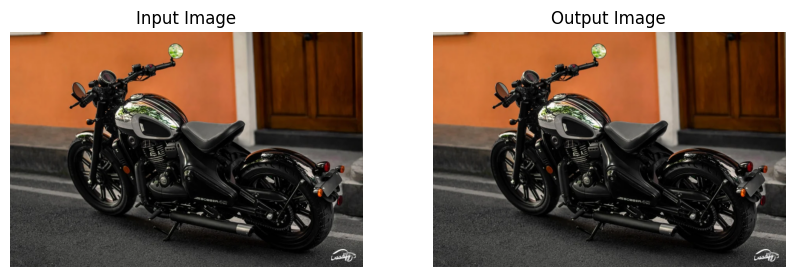

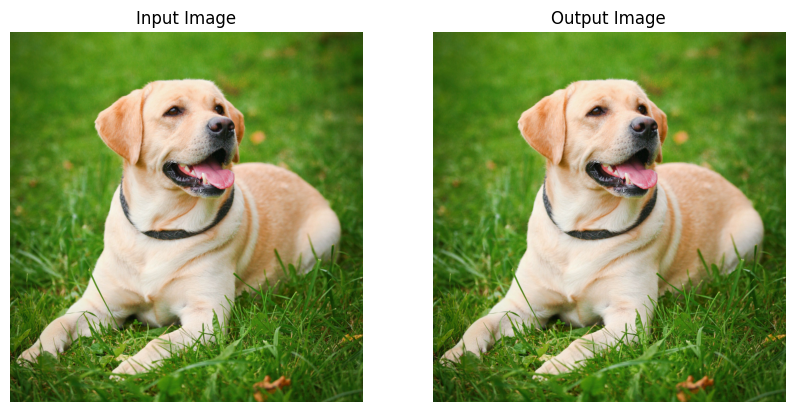

In [ ]:
# Define the draw_bounding_box function
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h, label):
    color = (0,255,0)
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Define the on_upload function
def on_upload(change):
    uploaded_file = list(file_upload.value.values())[0]  # Extract the uploaded file
    image = Image.open(BytesIO(uploaded_file['content']))
    image_np = np.array(image)

    # Preprocess image
    blob = cv2.dnn.blobFromImage(image_np, 0.00392, (416,416), (0,0,0), True, crop=False)

    # Set input to the network
    net.setInput(blob)

    # Run forward pass through the network
    outs = net.forward(get_output_layers(net))

    # Find the detection with highest confidence
    max_confidence = 0
    best_detection = None
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and confidence > max_confidence:
                max_confidence = confidence
                best_detection = detection

    # Process best detection
    if best_detection is not None:
        scores = best_detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        center_x = int(best_detection[0] * image_np.shape[1])
        center_y = int(best_detection[1] * image_np.shape[0])
        w = int(best_detection[2] * image_np.shape[1])
        h = int(best_detection[3] * image_np.shape[0])
        x = center_x - w / 2
        y = center_y - h / 2
        label = str(classes[class_id])
        draw_bounding_box(image_np, class_id, confidence, int(x), int(y), int(x+w), int(y+h), label)

    # Display the input and output images in a subplot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(image_np)
    ax[1].set_title('Output Image')
    ax[1].axis('off')

    plt.show()

# Create the file upload widget
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
file_upload.observe(on_upload, names='_counter')

# Display the file upload widget
display(file_upload)